In [1]:
import numpy as np
import pandas as pd
import math
import codecs
import spacy
import json

import umap
import matplotlib.pyplot as plt

import textacy
import textacy.tm
import textacy.preprocessing

from functools import partial

from pointgrid import align_points_to_grid


In [2]:
xlsx = pd.read_excel('abstracts.xlsx')
xlsx.rename(columns={'Title':'title', 'Abstract':'abstract'}, inplace=True); del xlsx['Notes']

authors = []; texts = []


for index, row in xlsx.iterrows():

    # Break on the last line

    if type(row['abstract']) != str:
        break


    # Authors

    _a = row['First name'] + ' ' + row['Last name']
    
    if pd.notnull(row['Co1-Last']): _a += '; ' + row['Co1-First'] + ' ' + row['Co1-Last']
    if pd.notnull(row['Co2-Last']): _a += '; ' + row['Co2-First'] + ' ' + row['Co2-Last']
    if pd.notnull(row['Co3-Last']): _a += '; ' + row['Co3-First'] + ' ' + row['Co3-Last']
    if pd.notnull(row['Co4-Last']): _a += '; ' + row['Co4-First'] + ' ' + row['Co4-Last']
    if pd.notnull(row['Co5-Last']): _a += '; ' + row['Co5-First'] + ' ' + row['Co5-Last']
    if pd.notnull(row['Co6-Last']): _a += '; ' + row['Co6-First'] + ' ' + row['Co6-Last']
    if pd.notnull(row['Co7-Last']): _a += '; ' + row['Co7-First'] + ' ' + row['Co7-Last']


    # Keywords
    
    _k = ''

    if pd.notnull(row['keyword']): _k += row['keyword']
    if pd.notnull(row['keyword.1']): _k += ', ' + row['keyword.1']
    if pd.notnull(row['keyword.2']): _k += ', ' + row['keyword.2']
    if pd.notnull(row['keyword.3']): _k += ', ' + row['keyword.3']
    if pd.notnull(row['keyword.4']): _k += ', ' + row['keyword.4']


    # Text preprocessing

    _t = row['title'] + '. ' + row['abstract'] + ' ' + _k # Text

    
    
    # Remove references

    _t = _t.split('\nREFERENCE')[0]
    _t = _t.split('\nReference')[0]
    _t = _t.split('\nreference')[0]
    _t = _t.split(' References:')[0]
    _t = _t.split('References\n')[0]
    # _t = _t.replace('\n', ' ')
    # print(list(textacy.extract.keyword_in_context(_t, "reference", window_width=25, pad_context=True)))


    # Preprocessing

    preproc = textacy.preprocessing.make_pipeline(
        textacy.preprocessing.normalize.unicode,
        textacy.preprocessing.normalize.quotation_marks,
        textacy.preprocessing.normalize.whitespace,
        textacy.preprocessing.remove.brackets
    )
    
    _t = preproc(_t)


    # Save texts by author
    
    for a in _a.split("; "):
        if a in authors:
            index = authors.index(a)
            texts[index] = texts[index] + ' ' + _t
        else:
            authors.append(a)
            texts.append(_t)

len(texts)
# texts

371

In [19]:
# Parsing

# en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
en = textacy.load_spacy_lang("en_core_web_trf", disable=("parser",))

docs = []

for text in texts:
    doc = textacy.make_spacy_doc(text, lang=en)
    # doc = nlp(text)
    docs.append(doc)
    print(doc._.preview)

ror, mirror on the wall: Understanding the d...")
Doc(322 tokens: "An Imaginary of Efforts: The Technical and Cult...")
Doc(330 tokens: "Enframing or Animating Code? Reflections on Cyb...")
Doc(330 tokens: "Enframing or Animating Code? Reflections on Cyb...")
Doc(303 tokens: "Against Social AI. Recently, Barbro Fröding and...")
Doc(317 tokens: "Techno-Anthropocene on the Postphenomenological...")
Doc(756 tokens: "The Mediation of Technology in Quality of Care ...")
Doc(406 tokens: "The Mediation of Technology in Quality of Care ...")
Doc(350 tokens: "GAN; A Promising Approach to Mitigate the Probl...")
Doc(350 tokens: "GAN; A Promising Approach to Mitigate the Probl...")
Doc(341 tokens: ""Like": Aesthetic experience in a digital envir...")
Doc(303 tokens: "Against Automated Post-Work Imaginaries. The im...")
Doc(351 tokens: "How to be responsibly afraid of technology: A s...")
Doc(345 tokens: "Descriptive bias and the need of speculation in...")
Doc(357 tokens: "The construction of GE 

In [74]:
# Lematization

lemmas = []

ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ents = partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"})

for doc in docs:
    # extraction = textacy.extract.keyterms.textrank(doc, normalize='lemma')
    extraction = textacy.extract.terms(doc, ngs=ngs)
    # extraction = textacy.extract.basics.words(doc, filter_stops=True, filter_nums=True)
    lemmatization = textacy.extract.terms_to_strings(extraction, by="lemma")
    lemmas.append(list(lemmatization))

# TF-IDF

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(lemmas, tf_type="linear", idf_type="smooth")

doc_term_matrix


<371x3018 sparse matrix of type '<class 'numpy.float64'>'
	with 18855 stored elements in Compressed Sparse Row format>

0 0.4540355212349043
1 0.18542011583610213
2 0.21296491711232274
3 0.1475794458166708


<AxesSubplot:>

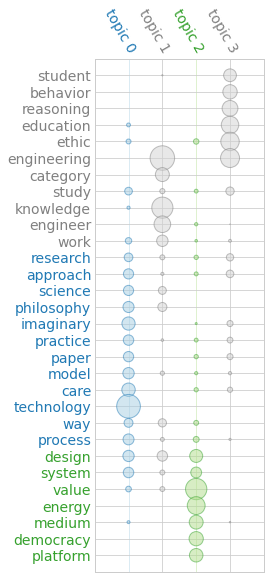

In [75]:
# import textacy
# from textacy.vsm import Vectorizer

model = textacy.tm.TopicModel('nmf', n_topics=4)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

dictionary_inverted = {id: term for term, id in dictionary.items()}

import operator

topics = []

for doc in model.get_doc_topic_matrix(doc_term_matrix):
    index, value = max(enumerate(doc), key=operator.itemgetter(1))
    # print(index, doc)
    topics.append(index)

# for weight in model.topic_weights(doc_topic_matrix):
#     print(doc)
# for topic_idx, terms in model.top_topic_terms(dictionary_inverted, top_n=3):
#     print(f"topic {topic_idx}: {'  '.join(terms)}")
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
     print(i, val)

model.termite_plot(doc_term_matrix, dictionary_inverted, n_terms=30, highlight_topics=[0,2,4,6,8,10])

 * creating mesh with size 61 61
 * filling mesh


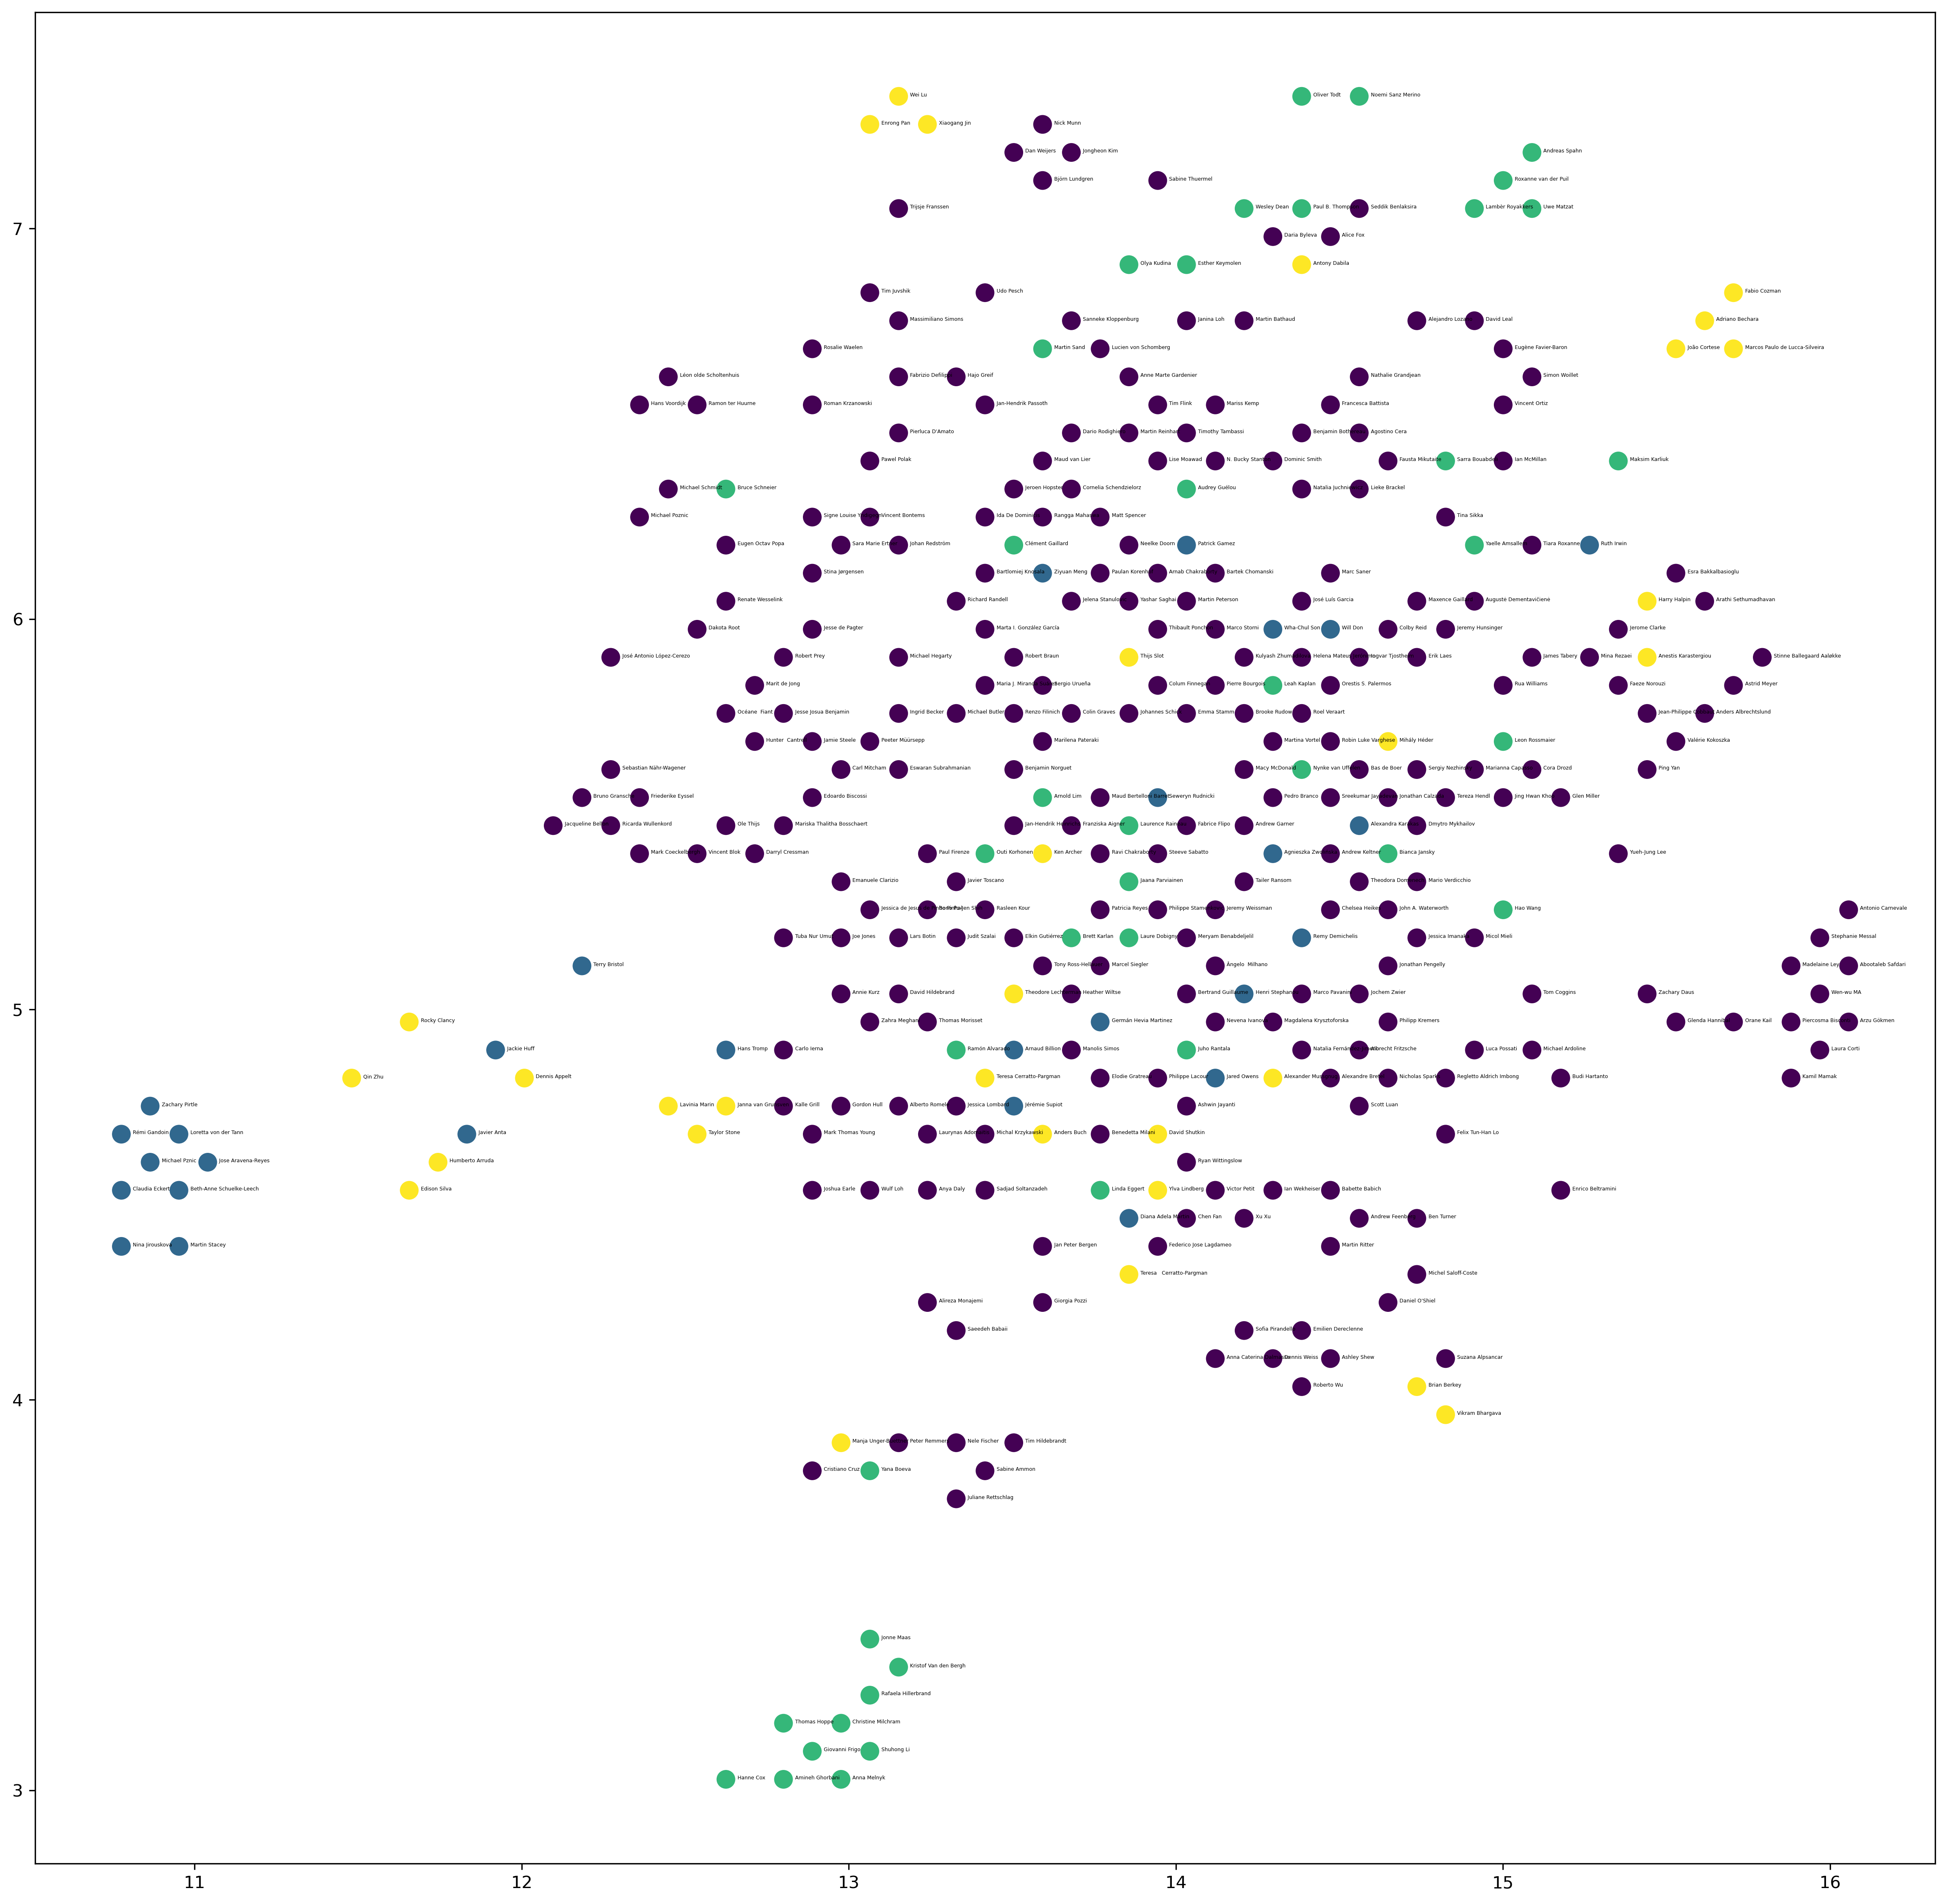

In [76]:
# UMAP

reducer = umap.UMAP(random_state=1, n_components=2, n_neighbors=100, min_dist=0.0)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=100, c=topics)

for i, txt in enumerate(authors):
    text = plt.annotate(' ' + authors[i], (x[i] + .03, y[i]))
    text.set_fontsize(3)
    

In [80]:
pairs = []

for indexA, a in enumerate(embedding):
    for indexB, b in enumerate(embedding):
        distance = dist = math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)
        if 0 < distance and distance < .15:
            x = (b[0] + a[0]) / 2
            y = (b[1] + a[1]) / 2
            intersection = list(set(lemmas[indexA]) & set(lemmas[indexB]))
            pairs.append([x,y, intersection])
            print('\n', x, y, intersection)
            # print()

len(pairs)


udy', 'scale', 'technology', 'history', 'time']

 13.724519729614258 6.297051429748535 ['technology', 'imaginary', 'practice', 'use']

 13.680514335632324 6.404821395874023 ['language', 'study', 'use', 'world', 'technology']

 14.076559066772461 4.860115051269531 ['interface', 'ethic', 'reflection', 'hand', 'technology', 'topic', 'system', 'perspective']

 14.032554626464844 4.824192047119141 ['paper', 'element', 'technology', 'topic', 'position']

 14.076559066772461 4.931962013244629 ['sense', 'condition', 'project', 'study', 'level', 'relation', 'technology', 'understanding', 'emergence']

 13.988550186157227 4.860115051269531 ['sense', 'approach', 'interaction', 'automation', 'account', 'term', 'value', 'use', 'possibility', 'relation', 'technology']

 14.032554626464844 4.9678850173950195 ['technology', 'paper', 'medium', 'possibility']

 13.372478485107422 5.363042831420898 ['element', 'term', 'hand', 'possibility', 'structure', 'way', 'system', 'understanding']

 13.416483879089

1002

In [81]:
# Save files

json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(authors, codecs.open('../src/data/authors.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(lemmas, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(pairs, codecs.open('../src/data/pairs.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(topics, codecs.open('../src/data/topics.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)